#SETUP AND CONFIGURATION

Install Dependencies and configure setup

In [ ]:
!pip install labelme opencv-python matplotlib albumentations

In [ ]:
!pip install cloud-tpu-client
!pip install tensorflow==2.12.0

In [1]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
IMAGES_PATH = os.path.join('/content/drive/MyDrive', 'face_detection', 'images')

In [4]:
# Import necessary libraries
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import uuid
import os
import shutil

import tensorflow as tf
import json
from matplotlib import pyplot as plt

#COLLECT IMAGES

Capture Images using OpenCV + JavaScript

In [ ]:
#MULTIPLE RANDOM IMAGES CAPTURE

# JavaScript function to capture images automatically
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const video = document.createElement('video');
            video.style.display = 'block';
            document.body.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            await new Promise(resolve => setTimeout(resolve, 2000));  // Auto-capture after 2 sec

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            video.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

# Capture multiple images automatically
num_images = int(input("Enter the number of images to capture: "))

captured_images = []
for i in range(num_images):
    print(f"Capturing image {i + 1}/{num_images}...")

    # Generate a random wait time (between 2 to 3 seconds)
    wait_time = random.uniform(2, 3)
    print(f"Waiting {wait_time:.2f} seconds before capturing...")
    time.sleep(wait_time)

    # Capture the image
    image_filename = os.path.join(IMAGES_PATH, f"{uuid.uuid1()}.jpg")
    captured_image = take_photo(image_filename)
    captured_images.append(captured_image)
    print(f"Image {i+1} saved: {captured_image}")

print(f"\n {num_images} images successfully captured!")

# Function to convert image to Base64
def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return b64encode(img_file.read()).decode()

# Function to display images as thumbnails
def display_images(image_folder, max_width=100):
    image_files = glob.glob(f"{image_folder}/*.jpg")

    if not image_files:
        print("No images found.")
        return

    # Convert each image to a base64 string
    image_tags = ''.join(
        f'<img src="data:image/jpeg;base64,{encode_image(img)}" width="{max_width}px" style="margin:5px; border-radius:10px;">'
        for img in image_files
    )

    display(HTML(f'<div style="display:flex; flex-wrap:wrap;">{image_tags}</div>'))

# Show all captured images as thumbnails
display_images(IMAGES_PATH)

Annotate Images with LabelMe

In [ ]:
!labelme

2025-03-09 10:43:43.821 | INFO     | labelme.config:get_config:66 - Loading config file from: /root/.labelmerc
QObject::moveToThread: Current thread (0x19448f0) is not the object's thread (0x2e5c320).
Cannot move to target thread (0x19448f0)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.11/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl.



Load Images Into Tensorflow Pipeline

In [ ]:
images = tf.data.Dataset.list_files('/content/drive/MyDrive/face_detection/images/*.jpg')

In [ ]:
images.as_numpy_iterator().next()

In [5]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

View Raw Images with matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

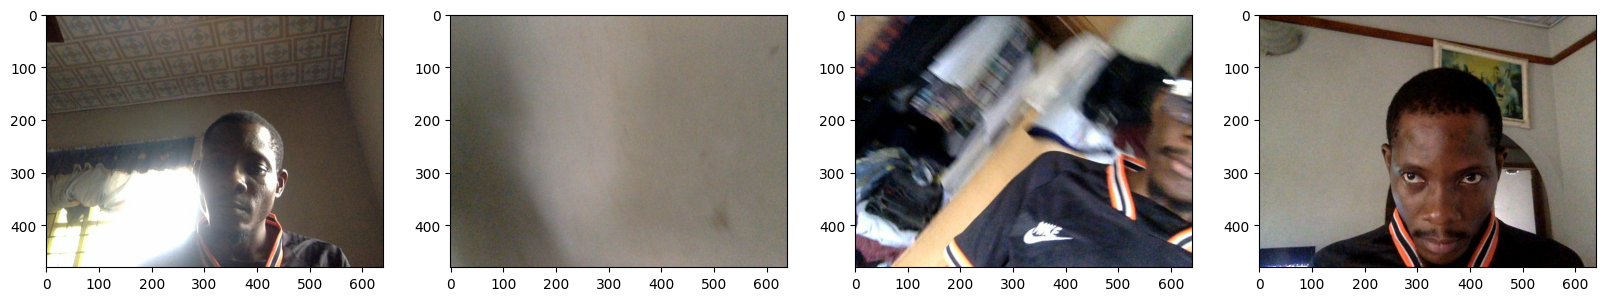

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

#SPLIT COLLECTED IMAGES INTO TRAIN(70), TEST (14) AND VAL(13) FOLDERS

Move Matching Labels

In [ ]:
BASE_PATH = '/content/drive/MyDrive/face_detection'
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join(BASE_PATH, folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join(BASE_PATH,'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join(BASE_PATH,folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)
            print(f"Moved: {existing_filepath} → {new_filepath}")

#Using Albumentations to apply Image Augmentation on Images and Labels

Setup Albumentations Transform Pipeline

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

Load a Train Image and Annotation

In [ ]:
img = cv2.imread(os.path.join(BASE_PATH,'train', 'images','0f760d42-fcce-11ef-8904-0242ac1c000c.jpg'))
print(img)

In [ ]:
with open(os.path.join(BASE_PATH, 'train', 'labels', '0f760d42-fcce-11ef-8904-0242ac1c000c.json'), 'r') as f:
    label = json.load(f)

In [ ]:
label

In [ ]:
type(label)

In [ ]:
label['shapes'][0]['label']

In [ ]:
label['shapes'][0]['points']

Extract Coordinates and rescale to match image resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

In [ ]:
coords = list(np.divide(coords, [640,480,640,480]))

In [ ]:
coords

Apply Augmentations and Query Results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented.keys()

In [ ]:
augmented['bboxes'][0][2:]

In [ ]:
augmented['bboxes']

In [ ]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

#Build and Run Augmentation Pipeline

In [ ]:
AUGMENTED_PATH = '/content/drive/MyDrive/face_detection/augmented_data'

for partition in ['train','test','val']:
    for image in os.listdir(os.path.join(BASE_PATH, partition, 'images')):
        img = cv2.imread(os.path.join(BASE_PATH, partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(BASE_PATH, partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join(AUGMENTED_PATH, partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join(AUGMENTED_PATH, partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Load Augmented Images to Tensorflow Dataset

In [6]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/face_detection/augmented_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [7]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/face_detection/augmented_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [8]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/face_detection/augmented_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [9]:
train_images.as_numpy_iterator().next()

array([[[0.99699754, 0.99852943, 0.98719364],
        [1.        , 1.        , 0.99509805],
        [1.        , 1.        , 1.        ],
        ...,
        [0.41299018, 0.3973039 , 0.3855392 ],
        [0.38952205, 0.37726715, 0.39736518],
        [0.08541667, 0.07702206, 0.11629902]],

       [[0.99626225, 0.99626225, 0.99693626],
        [1.        , 1.        , 0.99914217],
        [1.        , 1.        , 0.9990196 ],
        ...,
        [0.40741423, 0.38388482, 0.38388482],
        [0.41060048, 0.38235295, 0.41219363],
        [0.09105392, 0.06458333, 0.11017157]],

       [[0.9927696 , 0.9954044 , 0.966299  ],
        [0.99699754, 1.        , 0.9783088 ],
        [0.9965686 , 0.9965686 , 0.9887255 ],
        ...,
        [0.3893995 , 0.3658701 , 0.37371323],
        [0.42892158, 0.39166668, 0.42150736],
        [0.16041666, 0.1264706 , 0.17450981]],

       ...,

       [[0.34154412, 0.31115195, 0.27340686],
        [0.33884802, 0.29963234, 0.26433823],
        [0.38878676, 0

#Prepare Labels

In [10]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

Load Labels into Tensorflow Dataset

In [11]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/face_detection/augmented_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/face_detection/augmented_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/face_detection/augmented_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

#Combine Loaded Images and Labels

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

Creating Final Datasets

In [16]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [17]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [18]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

View Images and Annotations

In [20]:
data_samples = train.as_numpy_iterator()

In [21]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    sample_image = sample_image.copy()
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

#Build Deep Learning

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

Download and Summarize VGG

In [ ]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

Build Neural Network instance

In [26]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

Test out Neural Network

In [27]:
facetracker = build_model()

In [ ]:
facetracker.summary()

In [29]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
classes, coords = facetracker.predict(X)

In [ ]:
classes, coords

#Define Losses and Optimizers

Define Optimizers and Decay

In [33]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [34]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

Create Localization Loss and Classification loss

In [35]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [36]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [37]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.172388>

In [38]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7201181>

In [39]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.172388>

#Train Neural Network

Custom Model Class

In [40]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [41]:
model = FaceTracker(facetracker)

In [42]:
model.compile(opt, classloss, regressloss)

Train Model

In [43]:
logdir='/content/drive/MyDrive/face_detection/logs'

In [44]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
checkpoint_path = "/content/drive/MyDrive/face_detection/model/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='total_loss',
    mode='min',
    verbose=1
)

In [ ]:
# ✅ Load checkpoint if it exists
if os.path.exists(checkpoint_path + ".index"):
    print("Checkpoint found! Loading weights...")
    model.load_weights(checkpoint_path)
else:
    print("No checkpoint found. Training from scratch.")

In [ ]:
hist = model.fit(train.take(100), epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Model Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Make Predictions

In [100]:
test_data = test.as_numpy_iterator()

In [101]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    sample_image = sample_image.copy()
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

Save Model

In [69]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('/content/drive/MyDrive/face_detection/model/facedetector.h5')

In [ ]:
facetracker = load_model('/content/drive/MyDrive/face_detection/model/facedetector.h5')

#Real-Time Detection

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import time
import uuid
import os
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from base64 import b64decode
import PIL.Image
import io

# Load the face tracking model
facetracker = tf.keras.models.load_model("/content/drive/MyDrive/face_detection/model/facedetector.h5")

# Define save directory
IMAGES_PATH = "/content/drive/MyDrive/face_detection/captured_faces"
os.makedirs(IMAGES_PATH, exist_ok=True)

captured_images = []  # List to store captured images
capture_interval = 4  # Capture every 4 seconds
last_capture_time = time.time()

In [ ]:
# JavaScript to capture an image from the webcam and send it to Python
js_code = """
async function captureFrame() {
    const video = document.createElement('video');
    video.style.position = 'absolute';
    video.style.top = '-100px';
    document.body.appendChild(video);

    const stream = await navigator.mediaDevices.getUserMedia({ video: true });
    video.srcObject = stream;
    await video.play();

    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const ctx = canvas.getContext('2d');

    function captureImage() {
        ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
        const dataUri = canvas.toDataURL('image/jpeg');
        google.colab.kernel.invokeFunction('notebook.capture_image', [dataUri], {});
    }

    setInterval(captureImage, 4000);  // Capture every 4 seconds
}

captureFrame();
"""
display(Javascript(js_code))

In [114]:
def capture_image(data_uri):
    global last_capture_time

    # Decode base64 image
    image_bytes = b64decode(data_uri.split(',')[1])
    image = PIL.Image.open(io.BytesIO(image_bytes))
    frame = np.array(image)

    # Convert RGB to BGR for OpenCV
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    # Resize for face detection
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    # Predict face bounding box
    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Draw bounding box
        start_point = tuple(np.multiply(sample_coords[:2], [frame.shape[1], frame.shape[0]]).astype(int))
        end_point = tuple(np.multiply(sample_coords[2:], [frame.shape[1], frame.shape[0]]).astype(int))
        cv2.rectangle(frame, start_point, end_point, (255, 0, 0), 2)

        # Capture image every 4 seconds
        if time.time() - last_capture_time >= capture_interval:
            img_name = os.path.join(IMAGES_PATH, f"{uuid.uuid1()}.jpg")
            cv2.imwrite(img_name, frame)
            captured_images.append(img_name)
            last_capture_time = time.time()
            print(f"📸 Image Captured: {img_name}")

    # Show the frame
    cv2_imshow(frame)

# Register function to handle JavaScript input
from google.colab import output
output.register_callback('notebook.capture_image', capture_image)


In [ ]:
from IPython.display import display
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt

# Set thumbnail size
thumb_size = (100, 100)

# Number of columns per row
cols = 6

# Load images and display them in a grid
fig, axes = plt.subplots(nrows=(len(captured_images) // cols) + 1, ncols=cols, figsize=(18, 12))

# Flatten axes array if there's more than one row
axes = axes.flatten() if len(captured_images) > 1 else [axes]

for i, img_path in enumerate(captured_images):
    img = Image.open(img_path).resize(thumb_size)

    # Show image in subplot
    axes[i].imshow(img)
    axes[i].axis("off")  # Hide axes

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()